In [6]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [7]:
import sys, os
sys.path.append(os.path.abspath("../src"))


In [10]:
from setup_nltk import download_nltk_resources

download_nltk_resources()

from preprocessing import preprocess_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
ds = load_dataset("FredZhang7/all-scam-spam")
df = ds["train"].to_pandas()

Generating train split: 100%|██████████| 42619/42619 [00:00<00:00, 50554.86 examples/s]


# Missing values

In [13]:
missing_counts = df.isnull().sum()
missing_counts


text       0
is_spam    0
dtype: int64

In [14]:
df.columns

Index(['text', 'is_spam'], dtype='object')

# Split train and test 

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["is_spam"], test_size=0.2, stratify=df["is_spam"])

In [16]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
train_df.to_csv("../data/splits/raw/train.csv", index=False)
test_df.to_csv("../data/splits/raw/test.csv", index=False)

Distilbert does not need any preprocessing so it will be finetuning without any preprocessing while logistic regression needs preprocessing

# Preprocessing

In [20]:
train_df["clean_text"] = train_df["text"].apply(preprocess_text)
test_df["clean_text"] = test_df["text"].apply(preprocess_text)

In [24]:
train_df.head()

,text,label,clean_text
10763,fre @ backgammon\n\nisrael approved plans this...,1,fre backgammon israel approv plan week major o...
9329,re : waha hubco\n\nwaha hubco :\nlinda are you...,0,waha hubco waha hubco linda go work primari in...
41771,Como se chama isso em português?,0,como se chama isso em portuguê
28366,wellesley list\n\ngeynille :\nhere is the list...,0,wellesley list geynil list woman attend presen...
7807,potential list for november\n\ndaren :\nhere i...,0,potenti list novemb daren list potenti deal no...


In [25]:
train_df["clean_text"]

10763    fre backgammon israel approv plan week major o...
9329     waha hubco waha hubco linda go work primari in...
41771                       como se chama isso em portuguê
28366    wellesley list geynil list woman attend presen...
7807     potenti list novemb daren list potenti deal no...
                               ...                        
6329     activ driver quantiti survey awar start collec...
42094                                        我正在看一本很有趣的书！📚
15190    candlestick chart fyi fallout forward mike rob...
34385    stock radar crow vcsc brand new stock attent v...
35855    someth unusu product less top second could loo...
Name: clean_text, Length: 34095, dtype: object

In [12]:
test_df["clean_text"]

22015    yummi frappachino hey let go get coffe realli ...
19522    rawhid present louis updat earlier version raw...
17185    california updat sourc report socal chairman j...
13556    vacat shirley problem vinc shirley crenshaw pm...
36779                                       spoil bed well
                               ...                        
13844    friday brown bag lunch option price vinc thank...
29542    old put wet horni dirti grandma rememb lust fr...
33213    new password dear applic applic process approv...
31252    revis weekend duti revis schedul equit cover r...
2316     alevel student sue � grade fix url date educ y...
Name: clean_text, Length: 8524, dtype: object

In [13]:
train_df.to_csv("../data/splits/train.csv", index=False)
test_df.to_csv("../data/splits/test.csv", index=False)

# EDA

In [15]:
print("Text length distribution:")
train_df['text_length'] = train_df['clean_text'].apply(lambda x: len(str(x)))
train_df['text_length'].describe()

Text length distribution:


count     34095.000000
mean        871.554451
std        2948.127039
min           0.000000
25%         128.000000
50%         347.000000
75%         828.000000
max      200506.000000
Name: text_length, dtype: float64

In [16]:
print("Text length distribution:")
test_df['text_length'] = test_df['clean_text'].apply(lambda x: len(str(x)))
test_df['text_length'].describe()

Text length distribution:


count      8524.000000
mean        882.255397
std        2793.487540
min           0.000000
25%         127.000000
50%         346.000000
75%         805.250000
max      102797.000000
Name: text_length, dtype: float64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che tu abbia già il testo pulito in df["clean_text"]
texts = df["clean_text"].dropna().astype(str)

# === CO-OCCURRENCE MATRIX ===
vectorizer = CountVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(texts)

# Convert to DataFrame (feature names = parole)
cooccurrence_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calcola co-occorrenze come matrice di correlazione (approssimata)
cooccurrence_matrix = cooccurrence_df.T @ cooccurrence_df

# Visualizza le prime 10 parole più co-occorrenti con una parola specifica
focus_word = "money"  # cambia se vuoi
if focus_word in cooccurrence_matrix.columns:
    print(f"🔗 Parole più co-occorenti con '{focus_word}':")
    display(cooccurrence_matrix[focus_word].sort_values(ascending=False)[1:11])
else:
    print(f"La parola '{focus_word}' non è tra le top features selezionate.")

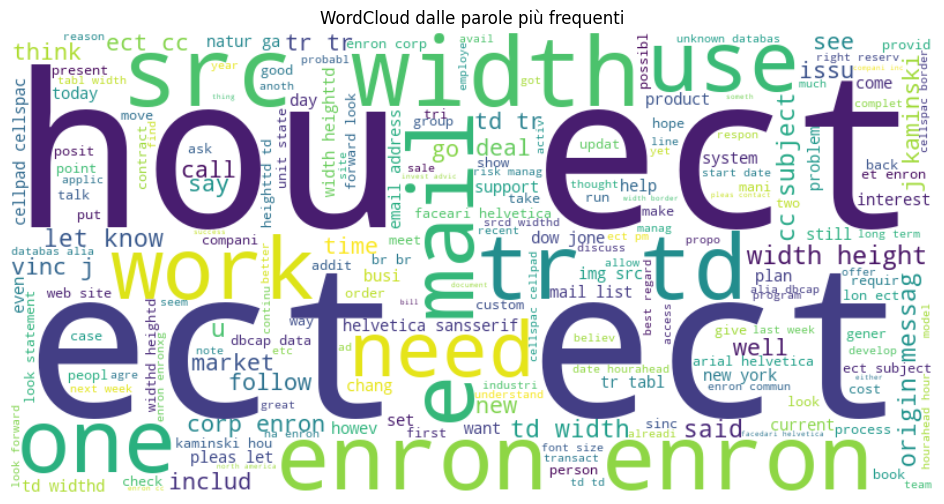

In [17]:
# Unisci tutti i testi in un'unica stringa
all_text = " ".join(train_df["clean_text"].dropna().astype(str).tolist())

# Crea la wordcloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200,
    colormap="viridis"
).generate(all_text)

# Mostra la WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud dalle parole più frequenti")
plt.show()


label
0    0.590966
1    0.409034
Name: count, dtype: float64
label
0    20149
1    13946
Name: count, dtype: int64


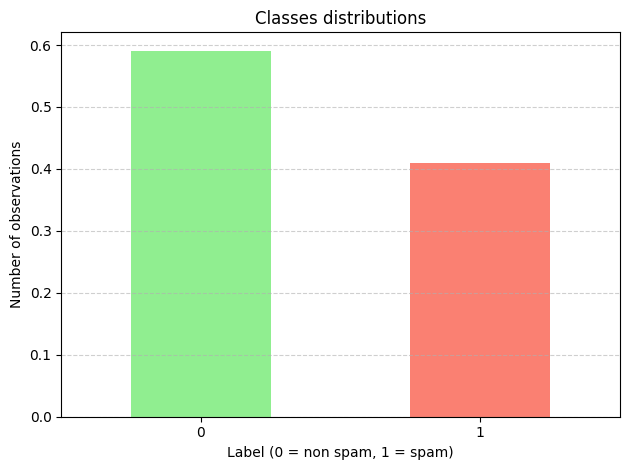

In [30]:
label_counts = train_df["label"].value_counts()
sum = label_counts.sum()
perc_label_counts=label_counts/sum
print(perc_label_counts)
print(label_counts)

perc_label_counts.plot(kind="bar", color=["lightgreen", "salmon"])
plt.xticks(rotation=0)
plt.title("Classes distributions")
plt.xlabel("Label (0 = non spam, 1 = spam)")
plt.ylabel("Number of observations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [21]:
train_df["label"].unique()

array([0, 1])

label
0    0.591037
1    0.408963
Name: count, dtype: float64
label
0    5038
1    3486
Name: count, dtype: int64


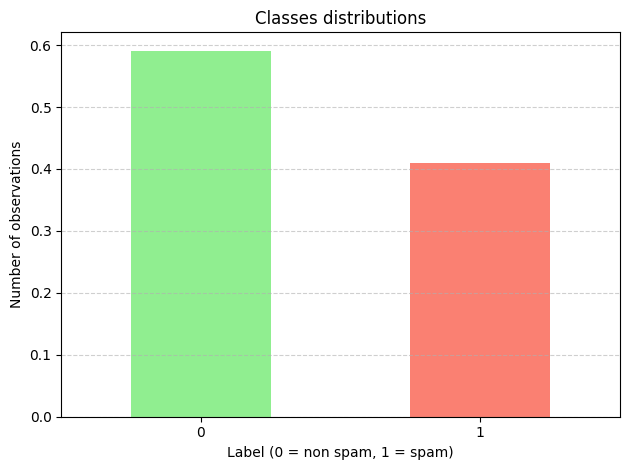

In [31]:
label_counts = test_df["label"].value_counts()

sum = label_counts.sum()
perc_label_counts=label_counts/sum
print(perc_label_counts)
print(label_counts)

perc_label_counts.plot(kind="bar", color=["lightgreen", "salmon"])
plt.xticks(rotation=0)
plt.title("Classes distributions")
plt.xlabel("Label (0 = non spam, 1 = spam)")
plt.ylabel("Number of observations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
test_df["label"].unique()

array([0, 1])